In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import skew, norm
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, optimal_leaf_ordering

#----------#

import argparse

from collections import defaultdict
import os

import matplotlib.pyplot as plt
import scipy.stats

import jax
from jax import pure_callback, random
import jax.numpy as jnp
import optax

import numpyro
from numpyro import handlers
from numpyro.contrib.funsor import config_enumerate, infer_discrete
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import SVI, TraceEnum_ELBO, init_to_value, MCMC, NUTS
from numpyro.infer.autoguide import AutoDelta
from numpyro.ops.indexing import Vindex

In [4]:
def FA_L1(X, num_factors, sparsity_scale=0.03, sparse=False):
    
    num_samples, num_features = X.shape

    # # Priors for the factor loadings with L1 regularization (Laplace prior)
    # with numpyro.plate('Features', num_factors):
    #     if sparse:
    #         f = numpyro.sample('features', dist.Laplace(0, sparsity_scale).expand([num_features]).to_event(1))
    #     else:
    #         f = numpyro.sample('features', dist.Normal(0, 1).expand([num_features]).to_event(1))

    f = numpyro.sample('features', dist.Laplace(jnp.zeros((num_factors, num_features)), sparsity_scale))
    # print(f.shape)

    # # Priors for the latent factors
    # with numpyro.plate('Samples', num_factors):
    #     if sparse:
    #         s = numpyro.sample('samples', dist.Laplace(0, sparsity_scale).expand([num_samples]).to_event(1))
    #     else:
    #         s = numpyro.sample('samples', dist.Normal(0, 1).expand([num_samples]).to_event(1))

    # print(s.shape)
    s = numpyro.sample('samples', dist.Laplace(jnp.zeros((num_factors, num_samples)), sparsity_scale))

    
    # Likelihood
    numpyro.sample('obs', dist.Normal(jnp.matmul(s.T, f), 1), obs=X)

In [5]:
# Mixure model EM algorithm

def uniformPDF(x, a, b):
    return 1/(b-a)

def exponentialPDF(x,λ):
    p = λ*np.exp(-λ*x)
    p[x<0] = 0.0
    return(p)

def normalPDF(x,μ,σ):
    p = 1.0/(σ*np.sqrt(2*np.pi))*np.exp(-(x-μ)**2/(2.0*σ**2.0))
    return(p)

def mixture_logLikelihood(x,rho,μ,σ,lam):
    pG = normalPDF(x,μ,σ)
    pE = exponentialPDF(x,lam)
    logLik = sum(np.log(rho*pG + (1-rho)*pE))
    return(logLik)

def EM(x,rho,μ,σ,lam,eps=0.0001):
    logLik = []
    while True:
        # calculate likelihood of x
        pG = normalPDF(x,μ,σ)
        pE = exponentialPDF(x,lam)
        logLik.append(sum(np.log(rho*pG + (1-rho)*pE)))
        # test for convergence
        if len(logLik)>1 and (logLik[-1] - logLik[-2]) < eps:
            break
        # calculate probabilities
        ppG = rho*pG/(rho*pG + (1-rho)*pE)
        ppE = (1-rho)*pE/(rho*pG + (1-rho)*pE)
        # update parameter
        rho = sum(ppG)/len(x)
        μ = sum(x*ppG)/sum(ppG)
        σ = np.sqrt(sum(ppG*(x-μ)**2)/sum(ppG))
        lam = sum(ppE)/sum(x*ppE)
        print(logLik[-1])
    logLik = np.array(logLik)
    return(logLik,rho,μ,σ,lam)

In [3]:
# Load TF x Position x Promoter tensor
genome = 'mm10'
win = 2
TFs = np.load(f'../results/{genome}/tensor_TFsvd1_tf_pos_prom.npy')

tf = TFs[0,:,:]


In [10]:


@config_enumerate
def Truncated_Normal(loc=0.0, scale, low=None, high=None, validate_args=None):
    return TruncatedDistribution(
        base_dist=dist.Normal(loc, scale),
        low=low,
        validate_args=validate_args,
    )

def gaussian_uniform_mixture_model(data):
    # Define priors for the mixture components
    weights = numpyro.sample('weights', dist.Dirichlet(.5*jnp.ones(2)))

    # Gaussian component
    loc = numpyro.sample('loc', dist.Normal(0, 10))
    scale = numpyro.sample('scale', dist.HalfCauchy(10))
    gaussian_component = dist.Normal(loc, scale)
    gaussian_component = dist.TruncatedNormal(loc, scale, low=0.0)
        
    # Exponential component
    rate = numpyro.sample('rate', dist.HalfCauchy(10))
    exponential_component = dist.Exponential(rate)

    # Combine mixture components
    # components = jnp.stack([gaussian_component, uniform_component], axis=-1)
    # selected_component = numpyro.sample('selected_component', dist.Categorical(weights))
    
    # Mixture distribution
    # numpyro.sample('obs', dist.TransformedDistribution(components[selected_component]), obs=data)


    # Mixture likelihood calculation
    mixture_likelihood = weights[0] * gaussian_component.log_prob(data) + \
                         weights[1] * exponential_component.log_prob(data)

    # Observed data
    numpyro.factor('obs', mixture_likelihood)
    #numpyro.sample('obs', gaussian_component)

def guide(data):
    # Use No-U-Turn Sampler (NUTS) for inference
    nuts_kernel = NUTS(gaussian_uniform_mixture_model)

    # Use MCMC to perform inference
    mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=100)
    
    # Run the inference
    mcmc.run(jax.random.PRNGKey(0), data)

    # Get the posterior samples
    posterior_samples = mcmc.get_samples()

    return posterior_samples

tf = TFs[0,:,:]
data = jnp.array(tf)

# Run the guide to get posterior samples
posterior_samples = guide(data)

sample:  95%|█████████▍| 1040/1100 [5:50:50<21:22, 21.38s/it, 1023 steps of size 6.76e-09. acc. prob=0.84] 

dict_keys(['loc', 'obs', 'scale'])


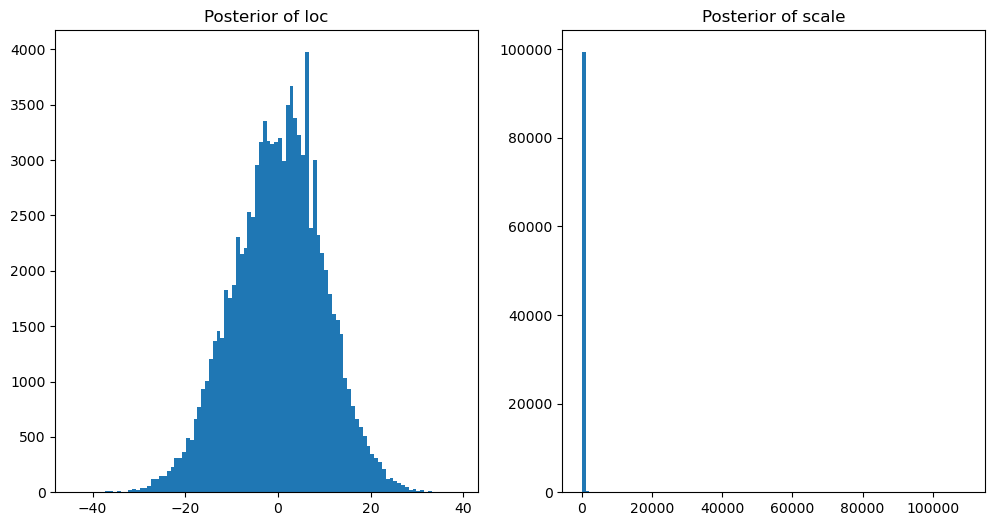

0.1486521 67.2491


In [73]:
print(posterior_samples.keys())

# Plot the posterior distributions of the mixture components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Posterior of loc')
plt.hist(posterior_samples['loc'], bins=100)
plt.subplot(1, 2, 2)
plt.title('Posterior of scale')
plt.hist(posterior_samples['scale'], bins=100)
plt.show()

# get loc and scale
loc = posterior_samples['loc'].mean()
scale = posterior_samples['scale'].mean()

print(loc, scale)

In [ ]:
@config_enumerate
def model(prior, obs, num_obs):
    p_A = numpyro.sample("p_A", dist.Beta(1, 1))
    p_B = numpyro.sample("p_B", dist.Beta(jnp.ones(2), jnp.ones(2)).to_event(1))
    p_C = numpyro.sample("p_C", dist.Beta(jnp.ones(2), jnp.ones(2)).to_event(1))
    with numpyro.plate("data_plate", num_obs):
        A = numpyro.sample("A", dist.Bernoulli(p_A), obs=obs["A"])
        # Vindex used to ensure proper indexing into the enumerated sample sites
        B = numpyro.sample(
            "B",
            dist.Bernoulli(Vindex(p_B)[A]),
            infer={"enumerate": "parallel"},
        )
        numpyro.sample("C", dist.Bernoulli(Vindex(p_C)[B]), obs=obs["C"])

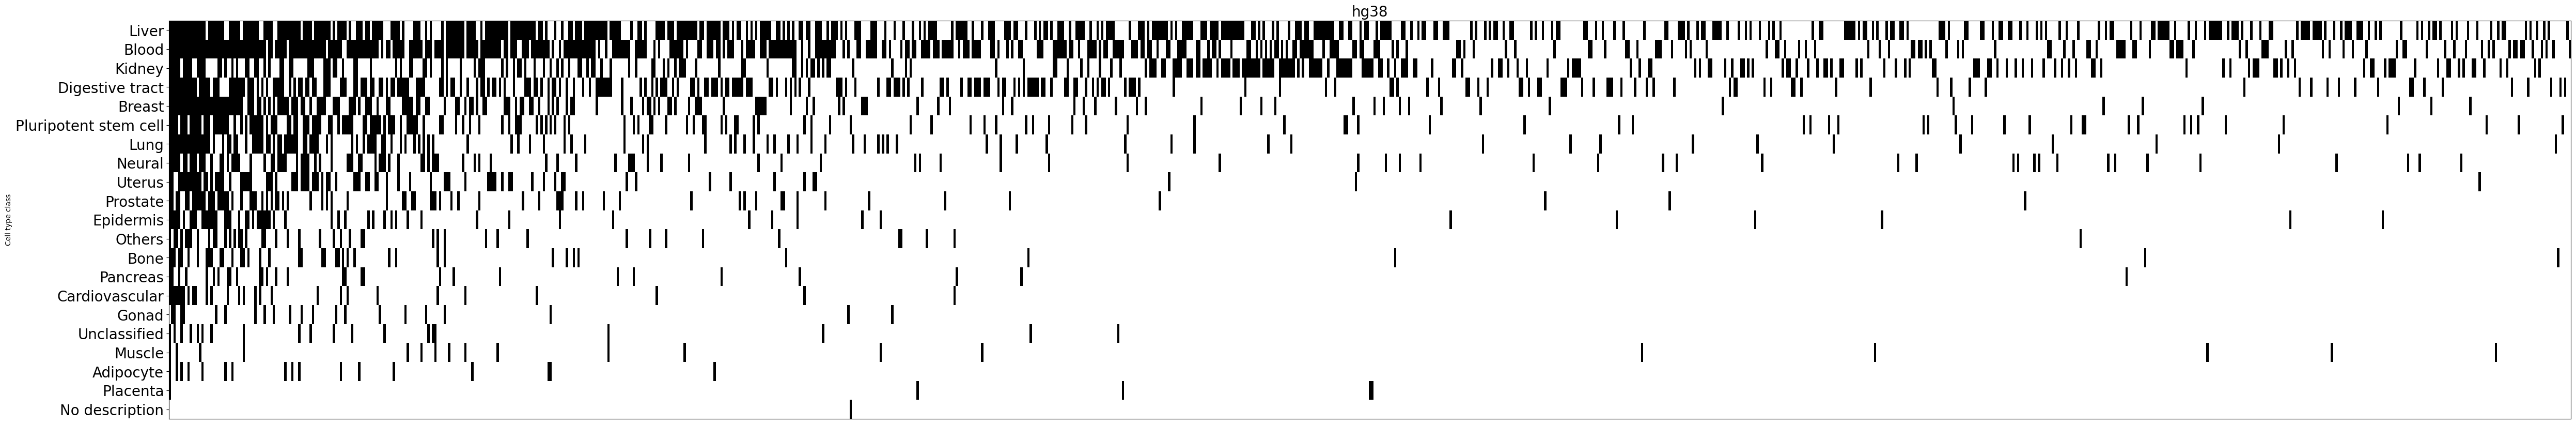

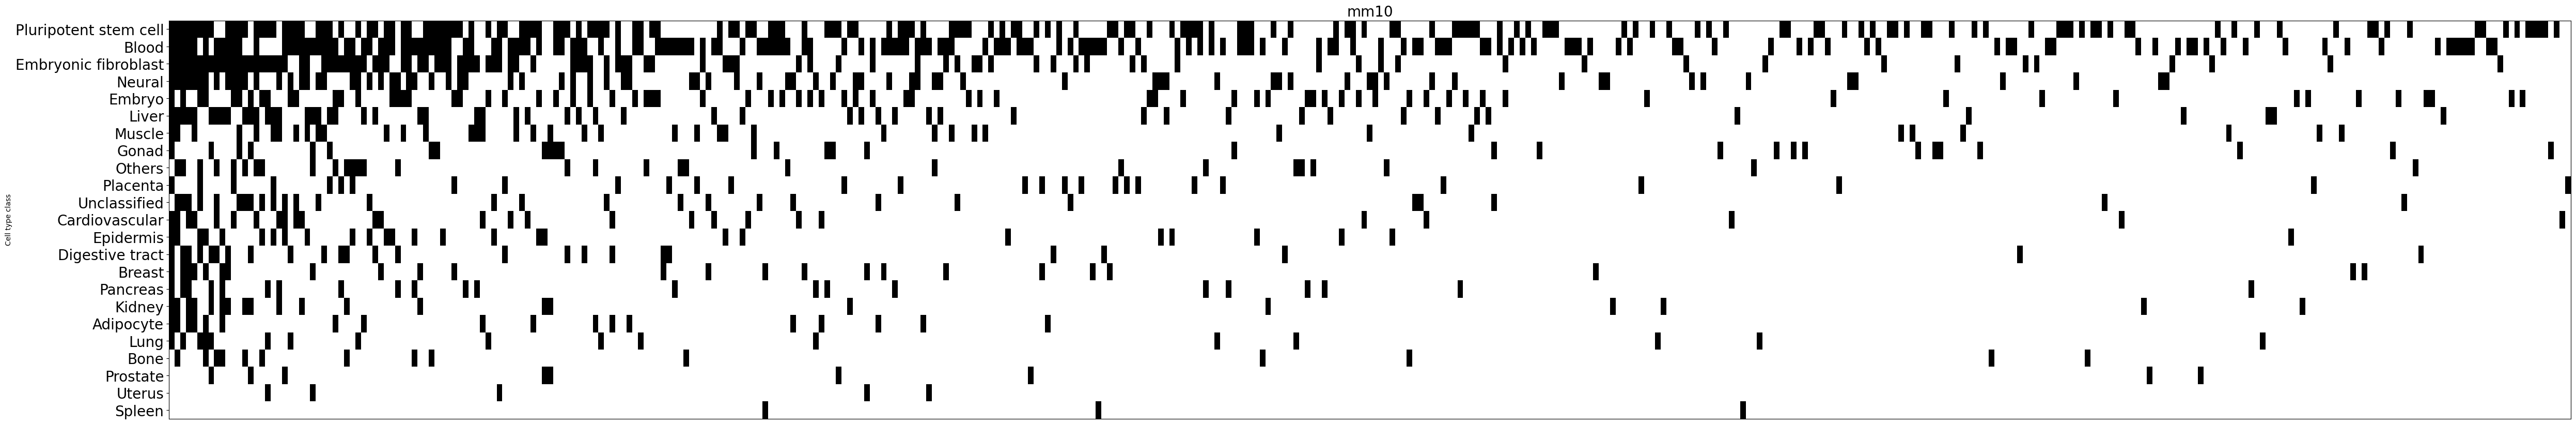

In [5]:
Genome = ['hg38', 'mm10']

for genome in Genome:
    infile = '../resources/experimentList_{}_TFs_only_QC_filtered.tab'.format(genome)
    experiment_table = pd.read_csv(infile, sep='\t', index_col=0)

    celltype_per_tf = experiment_table.pivot_table(index='antigen', columns='celltype_class', aggfunc='size', fill_value=0)

    celltype_per_tf[celltype_per_tf >0] = 1
    col_idx = np.argsort(celltype_per_tf.sum(0).values)[::-1]
    row_idx = np.argsort(celltype_per_tf.sum(1).values)[::-1]

    celltype_per_tf = celltype_per_tf.iloc[row_idx, col_idx]

    # plot
    fig, ax = plt.subplots(figsize=(60,10))
    im = ax.imshow(celltype_per_tf.transpose(), cmap='binary', interpolation='nearest', aspect='auto')
    ax.set_ylabel('Cell type class')
    ax.set_yticks(np.arange(len(celltype_per_tf.columns)))
    ax.set_yticklabels(celltype_per_tf.columns, fontsize=20)
    ax.set_xticks([])
    ax.set_title(f'{genome}', fontsize=20)

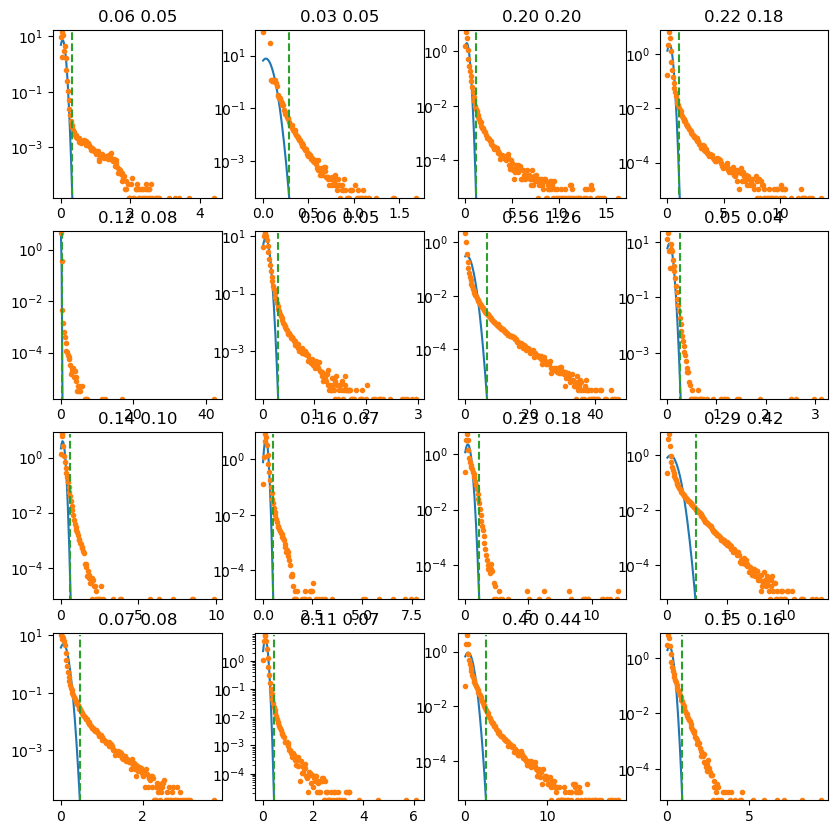

In [110]:
# Normalize

#for i in range(TFs.shape[0]):
fig, axes = plt.subplots(4,4, figsize=(10,10))
for i in range(16):
    tf = TFs[i].flatten()
    μ = tf.mean()
    σ = tf.std()

    TFs[i] = (TFs[i]-μ)/σ
    if False:
        n = len(tf)
        
        h,x = np.histogram(tf, bins=200, density=True)
        x = (x[:-1]+x[1:])/2
        p_x = 1/(σ*np.sqrt(2*np.pi))*np.exp(-(x-μ)**2/(2*σ**2))
        # get erf of 1/n

        eps = 1-1/n
        p_eps = norm.ppf(eps, μ, σ)
        f_high = (x>p_eps).sum()/n
        
        ax = axes.flatten()[i]
        ax.plot(x, p_x)
        ax.plot(x, h,'.')
        ax.plot([p_eps]*2,[h.min(),h.max()],'--')
        ax.set_yscale('log')
        ax.set_ylim(h[h>0].min(), 1.2*h.max())
        ax.set_title(f'{μ:.2f} {σ:.2f}')
    

(425, 100)


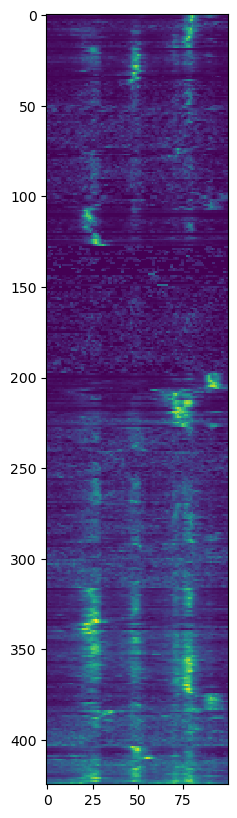

In [137]:
# Load promoterome and select a gene
promoterome = pd.read_csv(f'/home/jbreda/Promoterome/results/{genome}/promoterome_pm1kb_filtered.bed', sep='\t')
my_gene = 'Trp53'
#my_gene = 'Nfkb1'
#my_gene = 'Myc'
my_prom = promoterome.index[promoterome.gene == my_gene].values[0]
X = TFs[:,:,my_prom]
print(X.shape)

# Normalize on TF "noise"
dx = np.mean( (X[:,1:] - X[:,:-1])**2, axis=1)
X /= dx[:,None]
#X = X/np.max(X,axis=1,keepdims=True)
#X = X - X.mean(1)[:,None]
#X = X/X.std(1)[:,None]

# reodering
Z = linkage(X, 'ward', 'euclidean',optimal_ordering=True)
idx = leaves_list(optimal_leaf_ordering(Z, X))
X = X[idx,:]

fig, ax = plt.subplots(1,1, figsize=(5,10))
im = ax.imshow(X,interpolation='none')


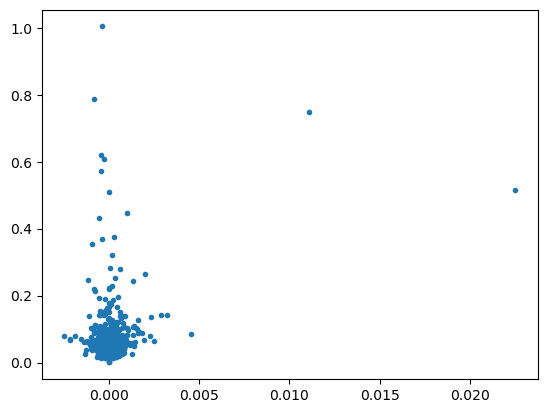

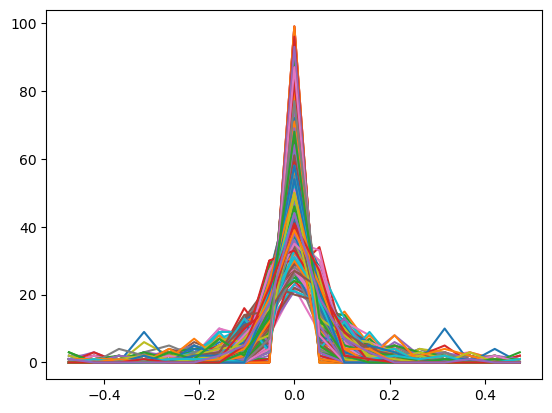

In [133]:

my_gene = 'Trp53'
#my_gene = 'Nfkb1'
#my_gene = 'Myc'
my_prom = promoterome.index[promoterome.gene == my_gene].values[0]
X_ = TFs[:,:,my_prom]
dx = X_[:,1:] - X_[:,:-1]

mu = dx.mean(1)
sigma = dx.std(1)
plt.plot(mu,sigma,'.')
plt.show()

X /= sigma[:,None]
bins = np.linspace(-.5,.5,20,endpoint=True)
H = np.zeros((len(bins)-1, X_.shape[0]))
for i in range(X_.shape[0]):
    h,x = np.histogram(dx[i,:],bins=bins)
    H[:,i] = h
#h,x = np.histogram(dx,bins=np.arange(-1,1,0.01))
x = (bins[1:] + bins[:-1])/2

plt.plot(x,H)
plt.show()


In [127]:
bins

array([-5.0000000e-01, -4.8000000e-01, -4.6000000e-01, -4.4000000e-01,
       -4.2000000e-01, -4.0000000e-01, -3.8000000e-01, -3.6000000e-01,
       -3.4000000e-01, -3.2000000e-01, -3.0000000e-01, -2.8000000e-01,
       -2.6000000e-01, -2.4000000e-01, -2.2000000e-01, -2.0000000e-01,
       -1.8000000e-01, -1.6000000e-01, -1.4000000e-01, -1.2000000e-01,
       -1.0000000e-01, -8.0000000e-02, -6.0000000e-02, -4.0000000e-02,
       -2.0000000e-02,  4.4408921e-16,  2.0000000e-02,  4.0000000e-02,
        6.0000000e-02,  8.0000000e-02,  1.0000000e-01,  1.2000000e-01,
        1.4000000e-01,  1.6000000e-01,  1.8000000e-01,  2.0000000e-01,
        2.2000000e-01,  2.4000000e-01,  2.6000000e-01,  2.8000000e-01,
        3.0000000e-01,  3.2000000e-01,  3.4000000e-01,  3.6000000e-01,
        3.8000000e-01,  4.0000000e-01,  4.2000000e-01,  4.4000000e-01,
        4.6000000e-01,  4.8000000e-01])

In [39]:
# Factor analysis with L1 regularization
num_factors = 4
numpyro.render_model(FA_L1, model_args=(X,num_factors), render_distributions=True)

# Running MCMC
kernel = NUTS(FA_L1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), X, num_factors, sparsity_scale=0.1)

# Getting the posterior samples
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [01:50<00:00, 13.63it/s, 255 steps of size 2.18e-02. acc. prob=0.81]


(4, 100)
(4, 425)


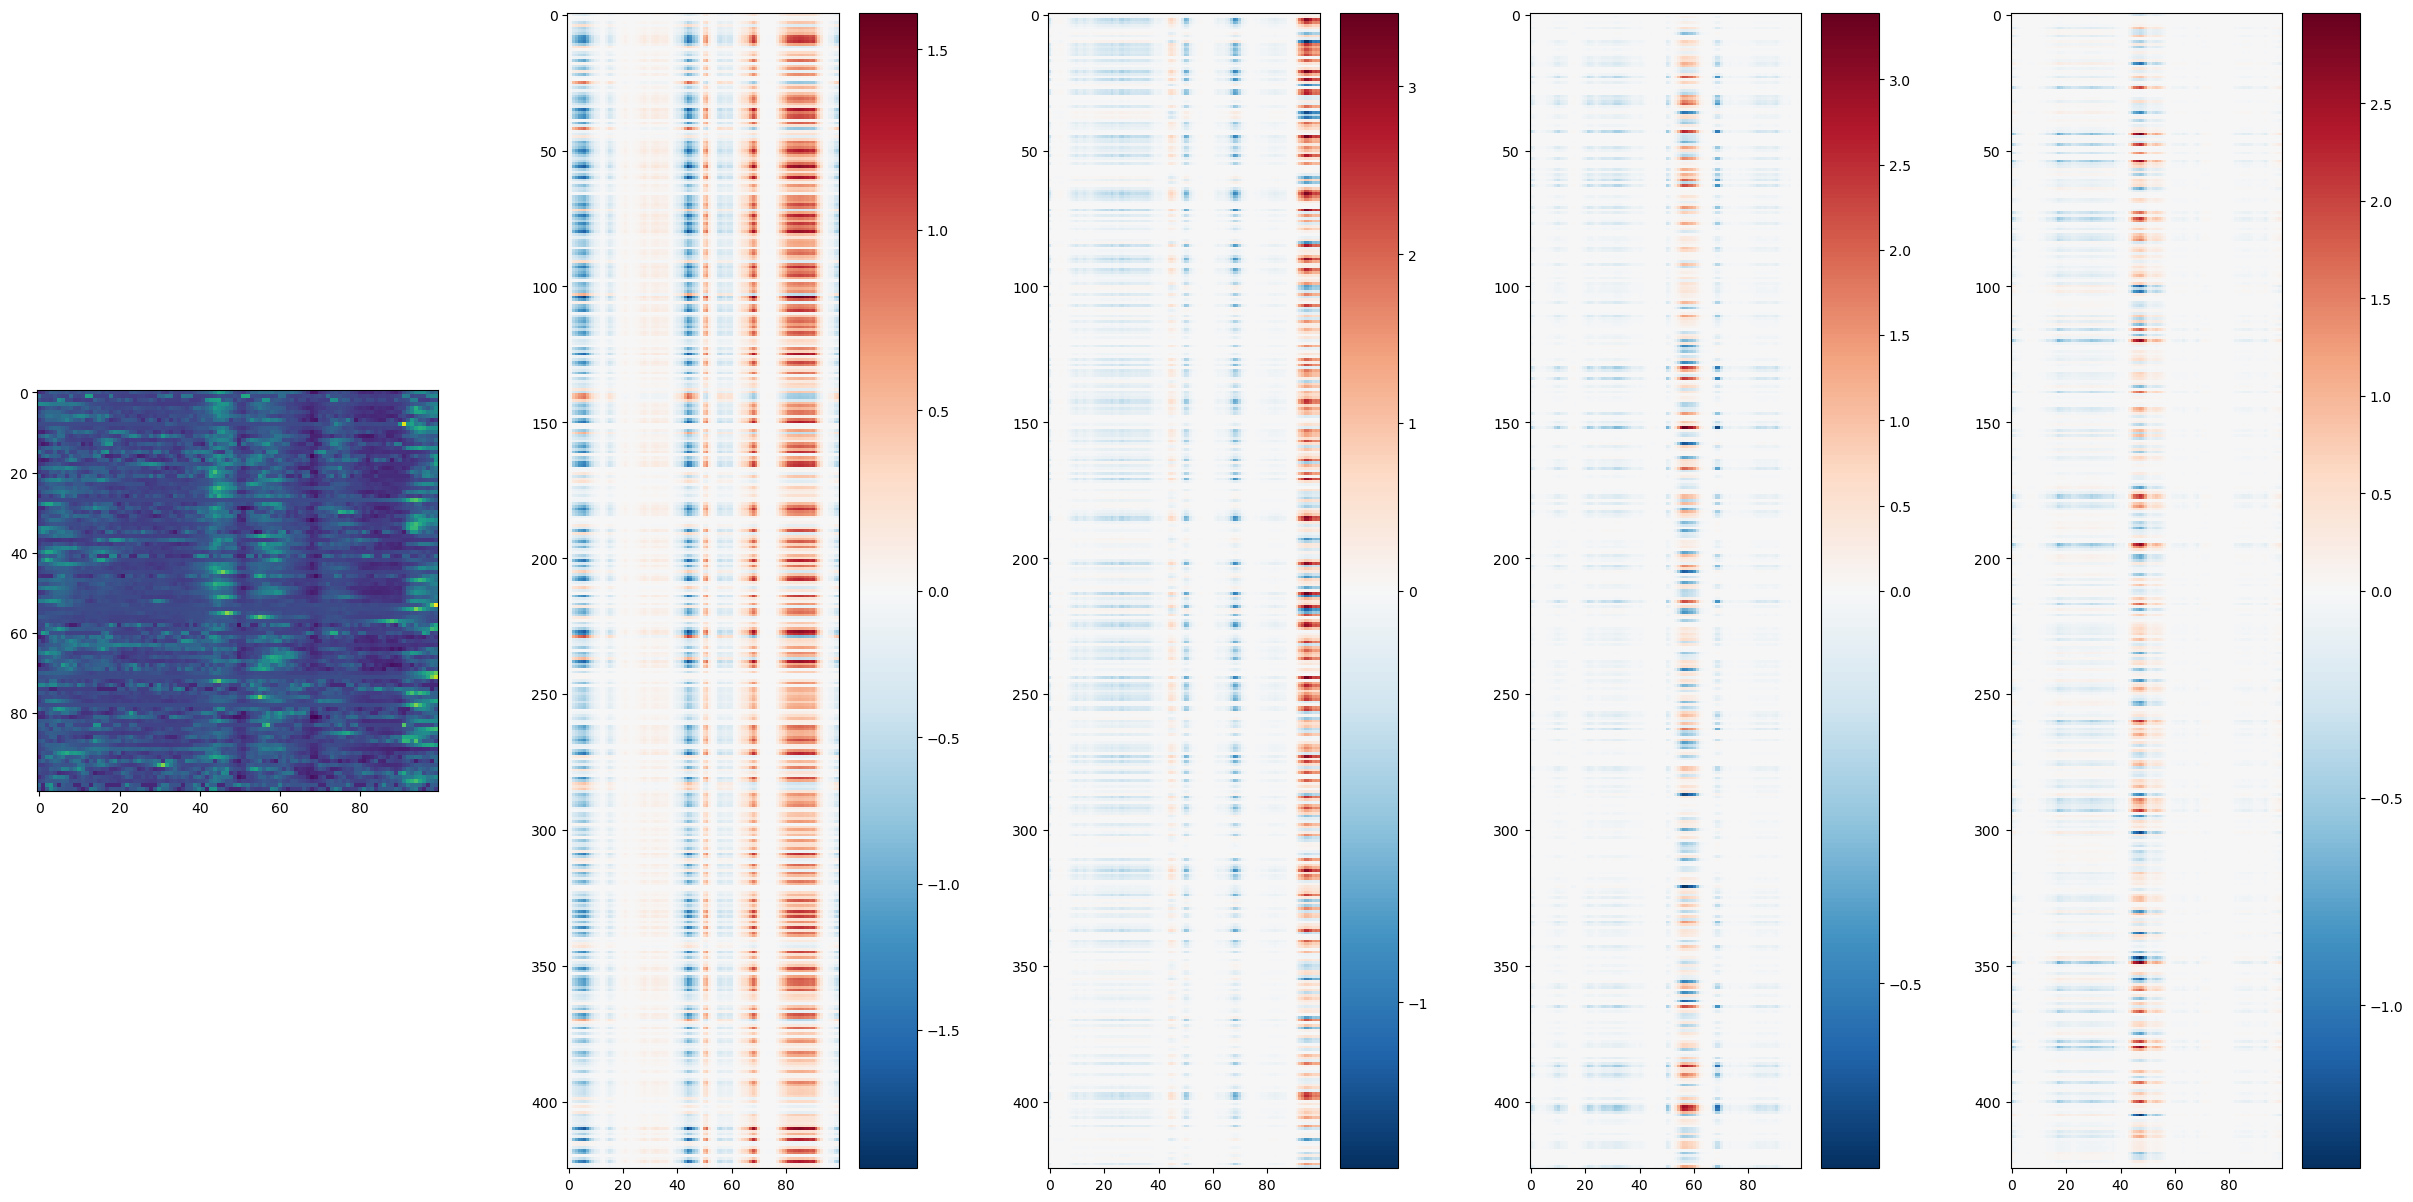

In [40]:
# plot the reconstructed X matrix
# feature = position along promoter
# sample = TF
f=posterior_samples['features'].mean(axis=0)
s=posterior_samples['samples'].mean(axis=0)
# flip sign of factors to match the sign of the skewness
s = s*np.repeat( np.sign(skew(s,1,keepdims=True)),s.shape[1],axis=1)
f = f*np.repeat( np.sign(skew(f,1,keepdims=True)),f.shape[1],axis=1)
print(f.shape)
print(s.shape)

fig, axes = plt.subplots(1,num_factors+1, figsize=(30,15))
ax = axes[0]
im = ax.imshow(X,interpolation='none')

for i in range(num_factors):
    ax = axes[i+1]

    X_i = jnp.matmul(s[[i],:].T, f[[i],:])

    # 0 in white, positive in red, negative in blue
    #ax.set_cmap('bwr') # a good start: blue to white to red colormap
    vmin = X_i.min()
    vmax = X_i.max()
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    im = ax.imshow(X_i,interpolation='none', cmap='RdBu_r', norm=norm)
    # show colorbar
    cbar = fig.colorbar(im, ax=ax)


    #im = ax.imshow(jnp.matmul(s[[i],:].T, f[[i],:]),interpolation='none')
    

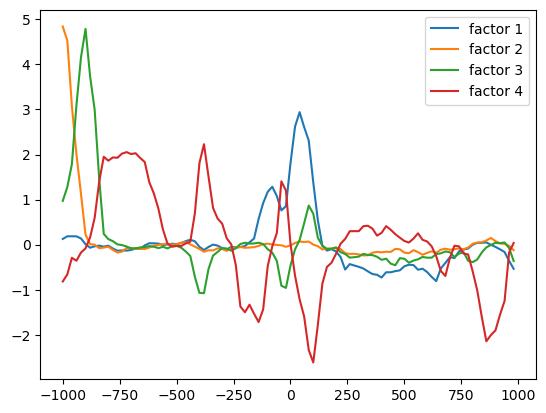

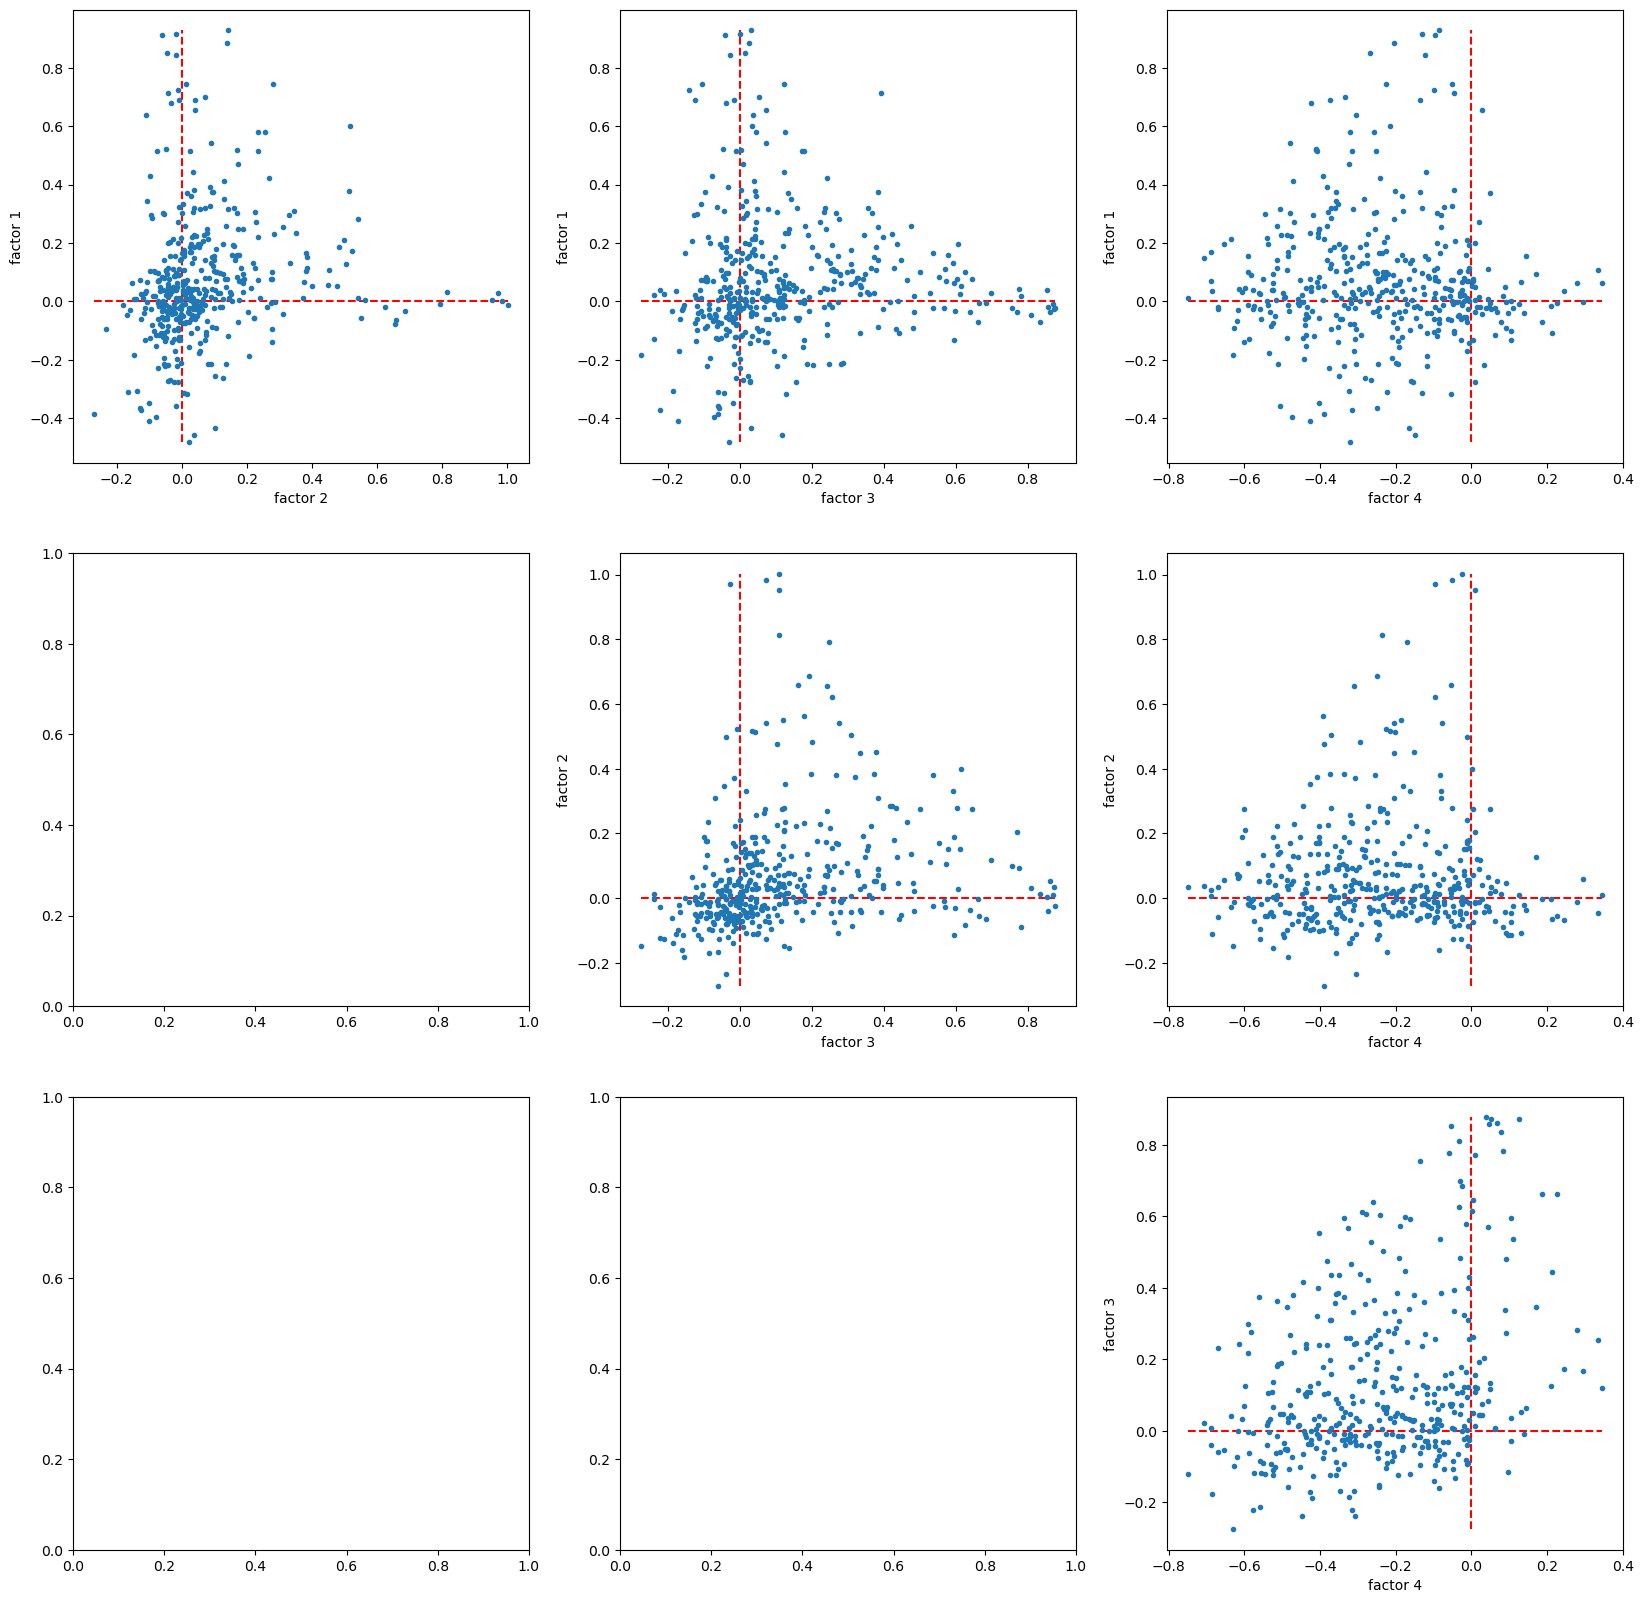

In [7]:
x = np.arange(-1000,1000,20)
plt.plot(x,f.T)
plt.legend([f'factor {i+1}' for i in range(num_factors)])
plt.show()


fig, axes = plt.subplots(num_factors-1,num_factors-1, figsize=(20,20))

for i in range(num_factors):
    for j in range(num_factors):
        if j>i:
            ax = axes[i,j-1]
            x_min = s[j,:].min()
            x_max = s[j,:].max()
            y_min = s[i,:].min()
            y_max = s[i,:].max()
            ax.plot([x_min, x_max], [0,0], 'r--')
            ax.plot([0,0], [y_min, y_max], 'r--')
            
            ax.plot(s[j,:], s[i,:], '.')
            ax.set_xlabel(f'factor {j+1}')
            ax.set_ylabel(f'factor {i+1}')
            

In [33]:
# rearange s by similarity
#D=pdist(s.T, 'correlation')


In [34]:
idx

array([256,  28, 157,  46, 255,  29,  15, 252, 314, 423, 341, 231,  40,
        22,  11, 127, 246, 317, 164, 129, 275, 292, 143, 398, 397, 145,
        76, 139, 217, 116, 265, 163, 353, 276, 325,  81,  50, 166,  74,
        49, 147, 208, 248, 153, 221, 282,  68,  95,  99,   8,  79,  55,
       113, 291, 132, 146, 316,  89, 302, 318,  14, 386, 250, 329, 383,
       395, 236, 136, 390, 226, 160, 233, 271, 262, 156,  64, 137, 235,
       184, 345,  47, 131,  34, 279,  65, 251, 324, 409, 337,   3,  52,
        85,  94, 288, 224,  90, 107,  67,  17, 202, 225, 244, 218, 213,
       186,  66, 185,   2,  24, 171, 315, 273,  45,  21,  72, 142,  13,
       103, 399, 247, 234, 169, 270, 269, 122, 406, 298, 172,   4, 278,
       404, 154,  91, 311,  12, 237, 370, 100, 287, 295, 219,  36, 355,
       330, 338, 102, 347, 301, 405, 189, 174, 245, 253, 375, 200, 206,
       114, 254,  10,  60,  38, 414, 214,  31, 309, 203, 159, 194,   9,
        30, 109,  37, 165,  77, 104, 281, 267,  80,  35, 410, 27